In [1]:
import hashlib
import os
import pickle

from IPython.display import display, SVG

from fastfusion.frontend.arch import Memory
from fastfusion.frontend.specification import Specification

import copy
from fastfusion import Specification
from fastfusion.mapper import Metrics

from fastfusion.mapper.FFM import make_pmappings, join_pmappings
from fastfusion.mapper.FFM._join_pmappings.sim import SIM
from fastfusion.util import set_n_parallel_jobs

set_n_parallel_jobs(12)

# TODO: Make a setting for the below two in the spec
# TODO: Generate pmappings one Einsum at a time. Once we've made compatibility, check it
# against the previously-generated compatibilities and stop if there's no match.
# TODO: Once the previous is done, also add a forward check. Once the compatibilities of
# a particular Einsum are generated, we can immediately check the previous Einsums.

def no_hybrid_mapping__filter(pm: SIM):
    fused_tensors = [x for x in pm.compatibility.tensors if x.resource_name != "MainMemory"]
    # Same # of fused loops above all fused tensors
    return len(set(len(x.loops) for x in fused_tensors)) <= 1

objective = lambda df: df['Total<SEP>latency']# * df['Total_Energy']
LOAD_FROM_CACHE = True

def get_fused_mappings(
        spec: Specification, 
        cache_key=None,
        parameterization="",
    ):
    spec = copy.deepcopy(spec)

    main_memory: Memory = spec.arch.nodes["MainMemory"]
    if parameterization == "Unfused":
        main_memory.constraints.tensors.keep = "All()"
    elif parameterization == "FlashAttention A":
        main_memory.constraints.tensors.keep = "I | Q | K | V | FFA"
    elif parameterization == "FFM":
        main_memory.constraints.tensors.keep = "~Intermediates()" #"# | AV | Z "
    elif parameterization == "TileFlow":
        spec.mapper.ffm._timeloop_style_even = True
    else:
        assert False, f"Parameterization {parameterization} not supported"
    print(main_memory.constraints.tensors.keep)
    print(main_memory.constraints.tensors.may_keep)

    os.makedirs("cache", exist_ok=True)
    if cache_key is not None:
        fname = parameterization + "-".join(str(x) for x in cache_key)
        if LOAD_FROM_CACHE and os.path.exists(f"cache/{fname}.pkl"):
            print(f"Loading from cache: {fname}")
            mappings = pickle.load(open(f"cache/{fname}.pkl", "rb"))
            return objective(mappings.data).min() if mappings is not None else None, mappings

    spec.calculate_component_energy_area()
    if LOAD_FROM_CACHE and cache_key is not None and os.path.exists(f"pmappings_cache/{fname}.pkl"):
        print(f"Loading from cache: {fname}")
        pmappings = pickle.load(open(f"cache/pmappings_{fname}.pkl", "rb"))
    else:
        pmappings = make_pmappings(spec)
        pickle.dump(pmappings, open(f"cache/pmappings_{fname}.pkl", "wb"))
    try:
        mappings = join_pmappings(spec, pmappings)
    except:
        mappings = None

    # TODO: the final joined pmappings have lambdas somewhere, which can't be pickled.
    if cache_key is not None:
        pickle.dump(mappings, open(f"cache/{fname}.pkl", "wb"))
        
    return objective(mappings.data).min() if mappings is not None else None, mappings

parameterization2edp = {}
parameterization2mappings = {}

# parameterizations = ["Unfused", "FlashAttention A", "TileFlow", "FFM"]
parameterizations = ["Unfused", "FFM"]
# for batch_size, n_tokens in [(64, 512), (1, 8192), (1, 16384), (1, 32768), (64, 8192), (64, 16384), (64, 32768)]:
for batch_size, n_tokens in [(1, 2048)]:
        for n_pes in [256]:# [64, 256]:
            spec = Specification.from_yaml(
                "../examples/arches/tpu_v4i_like.yaml",
                "../examples/workloads/gpt3_6.7B.yaml",
                jinja_parse_data={
                    "BATCH_SIZE": batch_size,
                    "N_TOKENS": n_tokens,
                }
            )
            spec.mapper.ffm.metrics = Metrics.LATENCY
            cache_key = (batch_size, n_tokens, n_pes)
            spec.arch.nodes["LocalBuffer"].spatial["Z"].fanout = n_pes
            for parameterization in parameterizations:
                x, mappings = get_fused_mappings(
                    spec,
                    cache_key=cache_key,
                    parameterization=parameterization,
                )
                parameterization2edp.setdefault((batch_size, n_tokens, n_pes), {})[parameterization] = x
                parameterization2mappings.setdefault((batch_size, n_tokens, n_pes), {})[parameterization] = mappings

WARNING Loading configuration file from /home/gilbertm/work/venv/fastfusion/config.yaml


All()
All
Loading from cache: Unfused1-2048-256
~Intermediates()
All


Generating pmapping templates for compute ScalarUnit Einsum I: 2it [00:00, 19.53it/s]
Generating pmapping templates for compute ScalarUnit Einsum Q: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum V: 0it [00:00, ?it/s]], ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]
Generating jobs:   5%|▌         | 1/20 [00:01<00:33,  1.78s/it]tes for compute MAC Einsum I: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum QK: 0it [00:00, ?it/s], 17.66it/s]
Generating pmapping templates for compute ScalarUnit Einsum K: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFA: 0it [00:00, ?it/s] 34.13it/s]
Generating pmapping templates for compute ScalarUnit Einsum Z: 0it [00:00, ?it/s]
Generating pmapping templates for compute ScalarUnit Einsum FFB: 0it [00:00, ?it/s]
Generating pmapping temp

Q: 9.05e10 total, 3.76e08 (1/241) valid, 3.61e05 (1/2.51e05) evaluated, 5.40e03 (1/1.68e07) Pareto-Optimal
V: 7.90e10 total, 1.99e08 (1/396) valid, 1.48e06 (1/5.36e04) evaluated, 7.94e03 (1/9.95e06) Pareto-Optimal
K: 7.43e10 total, 1.83e08 (1/405) valid, 1.45e06 (1/5.11e04) evaluated, 6.31e03 (1/1.18e07) Pareto-Optimal
Z: 7.39e10 total, 1.80e08 (1/411) valid, 1.51e06 (1/4.90e04) evaluated, 8.23e03 (1/8.98e06) Pareto-Optimal
QK: 8.70e09 total, 2.26e07 (1/385) valid, 3.74e05 (1/2.33e04) evaluated, 1.73e04 (1/5.02e05) Pareto-Optimal
AV: 8.34e09 total, 2.38e07 (1/350) valid, 4.07e05 (1/2.05e04) evaluated, 1.91e04 (1/4.37e05) Pareto-Optimal
FFA: 4.05e10 total, 5.22e07 (1/776) valid, 2.06e06 (1/1.97e04) evaluated, 7.36e03 (1/5.50e06) Pareto-Optimal
FFB: 2.31e10 total, 7.66e07 (1/301) valid, 2.51e05 (1/9.19e04) evaluated, 2.30e03 (1/1.00e07) Pareto-Optimal
QK_softmax: 9.84e05 total, 2.69e05 (1/4) valid, 1.56e05 (1/6) evaluated, 1.73e03 (1/569) Pareto-Optimal
I: 1.27e04 total, 4.28e03 (1/3) va

Compressing pmappings: 100%|██████████| 10/10 [00:00<00:00, 19.97it/s]


Not tracking ArrayDummy because it is never reserved for multiple pmappings.
Not tracking LocalBuffer because it is never reserved for multiple pmappings.
Not tracking MainMemory because it is never reserved for multiple pmappings.
Not tracking Register because it is never reserved for multiple pmappings.


Merging pmappings for FFA <--> FFB (10/10): 100%|██████████| 26/26 [00:01<00:00, 14.47it/s]
/home/gilbertm/work/active/fastfusion/fastfusion/mapper/FFM/_interface/main.py:162: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  joined._data = joined.data.fillna(0).reset_index(drop=True)


In [6]:
parameterization2edp

{(1, 2048, 256): {'Unfused': np.float64(106496.00043743511),
  'FFM': np.float64(106496.00043743511)}}

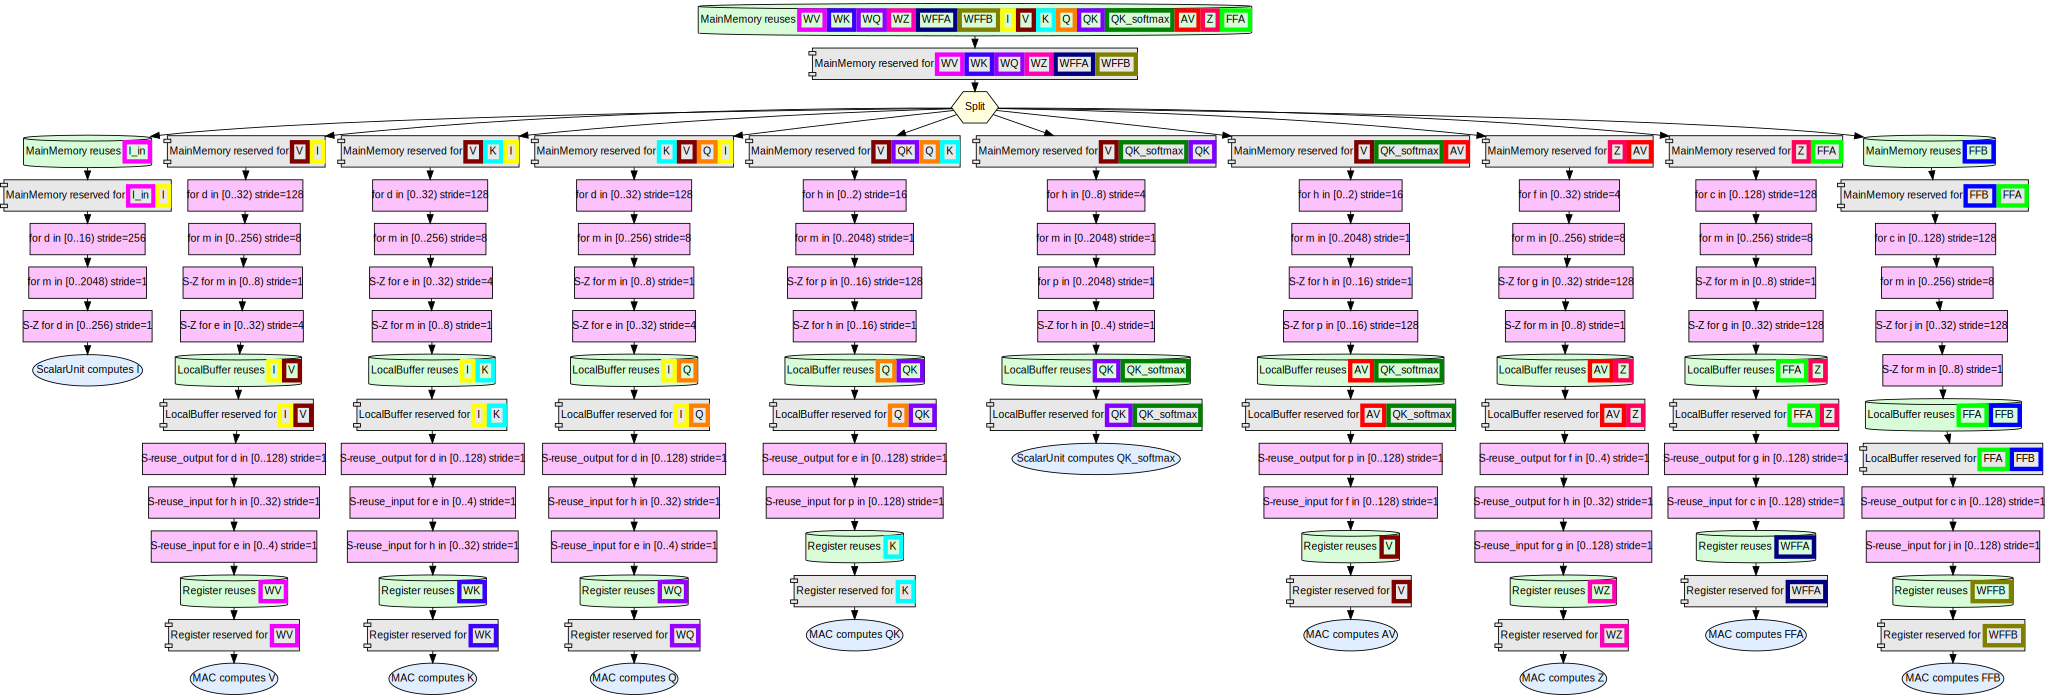

In [7]:
display(SVG(parameterization2mappings[(1, 2048, 256)]['FFM'].data.iloc[0]["Total<SEP>mapping"].render()))

In [4]:
results = parameterization2edp

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'font.size': 28})

def plot_default_formatting(ax, grid_axis='both'):
    ax.tick_params(axis='both', which='major')#, labelsize=20)
    ax.tick_params(axis='both', which='minor')#, labelsize=20)

    # Set legend ncols to 5
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    legend = ax.legend(fontsize=18, ncols=5, loc="upper center", bbox_to_anchor=(0.5, 1.2))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # ax.minorticks_on()
    # ax.grid(axis=grid_axis, which='major', linestyle='-', linewidth='0.3', color='gray')
    # ax.grid(axis=grid_axis, which='minor', linestyle='--', linewidth='0.1', color='lightgray')

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#ff0000",
]

def make_bar_chart(
    data,
    title,
    xlabel,
    ylabel,
    y_scale,
    output_file=None,
    normalize: bool = False,
    ylim=(None, None),
    xlim=(None, None),
):
    """
    Create a bar chart from the given data and save it as a PDF.
    """
    plt.figure(figsize=(16, 8))
    
    if isinstance(data, dict) and isinstance(next(iter(data.values())), dict):
        bar_width = 0.8 / len(data)
        keys = list(next(iter(data.values())).keys())
        x = range(len(keys))
        first = next(iter(data.values()))
            
        for i, (label, values) in enumerate(data.items()):
            bar_positions = [pos + i * bar_width for pos in x]
            to_plot = values
            if normalize:
                to_plot = {k: v / first[k] for k, v in values.items()}
            bars = plt.bar(bar_positions, to_plot.values(), width=bar_width, label=label, color=colors[i])
        plt.xticks([pos + (len(data) - 1) * bar_width / 2 for pos in x], keys)
        # plt.legend(loc='upper right', fontsize=10)
        plt.legend(fontsize=10, ncol=len(data), loc='upper center', bbox_to_anchor=(0.5, 0.75))
    else:
        keys = list(data.keys())
        bars = plt.bar(keys, data.values())
        

    # Set logarithmic scale for Y-axis if specified
    if y_scale == 'log':
        plt.yscale('log')

    # Add labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)

    # Rotate X-axis labels vertically
    # plt.xticks(rotation=90)
    
    plot_default_formatting(plt.gca(), grid_axis='y')
    
    if output_file is not None:
        with open(output_file, 'wb') as f:
            plt.savefig(f, format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

entries = {}

name_changes = {
    "Unfused": "Elementwise-Only",
    "FlashAttention A": "FlashAttention",
    "Fixed-Dataflow": "FLAT",
    "FlashAttention B": "FlashAttention B",
    "FFM": "Fast & Fusiest",
    # (64, 512, 64): "Big Batch\n64 Cores",
    (64, 512, 256): "Batch=64\nSeq. length=512",#\n256 Cores",
    # (1, 16384, 64): "Big Seq\n64 Cores",
    (1, 8192, 256): "Batch=1\nSeq. length=8k",#\n256 Cores",
    # (1, 32768, 256): "Bigger Seq\n256 Cores",
    (1, 32768, 256): "Batch=1\nSeq. length=32k",#\n256 Cores",
}

for k, v in results.items():
    if k not in name_changes:
        continue
    k = name_changes.get(k, k)
    entries[k] = {name_changes.get(k2, k2): 1/v[k2] if v[k2] else 0 for k2 in v}
    max_val = max(entries[k].values())
    for k2, v2 in entries[k].items():
        entries[k][k2] = v2 / max_val if max_val else 0

entries={k: v for k, v in sorted(entries.items(), key=lambda x: list(name_changes.values()).index(x[0]))}

# Transpose everything
entries2 = {}
for k, v in entries.items():
    for k2, v2 in v.items():
        entries2.setdefault(k2, {})[k] = v2
entries = entries2


# Print as a table
for name, e in entries2.items():
    print(f"{name}: {e}")
    
make_bar_chart(entries, title=None, xlabel=None, ylabel="Throughput (normalized)", y_scale='linear', output_file="mapsapce_compare.pdf", normalize=False, ylim=(0, 1), xlim=(None, None))

StopIteration: 

<Figure size 1600x800 with 0 Axes>